In [41]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [128]:
import pandas as pd
import numpy as np
from math import sqrt
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='dark')

# For traditional Time Series Models (ARIMA, ETS)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# For Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#For RNNs
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [23]:
raw_data = pd.read_csv('branch_optimization_Synthetic_Data.csv')

In [24]:
raw_data['date'] = pd.to_datetime(raw_data['date'],dayfirst=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18100 entries, 0 to 18099
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Branch_Code                  18100 non-null  int64         
 1   Branch_Name                  18100 non-null  object        
 2   Division                     18100 non-null  object        
 3   Territory                    18100 non-null  object        
 4   latitude                     18100 non-null  float64       
 5   longitude                    18100 non-null  float64       
 6   date                         18100 non-null  datetime64[ns]
 7   total_transaction_count      18100 non-null  int64         
 8   total_transaction_amt        18100 non-null  float64       
 9   staff_count                  18100 non-null  int64         
 10  tpsh                         18100 non-null  int64         
 11  customer_count               18100 non-nu

# We need to explore the nature of our data
###  We look at the seasonality of our target variables

In [59]:
daily_df = raw_data.groupby('date').agg({'total_transaction_count':'sum',
                                         'staff_count':'sum',
                                         'customer_count':'sum',
                                         'total_transaction_amt':'sum'})

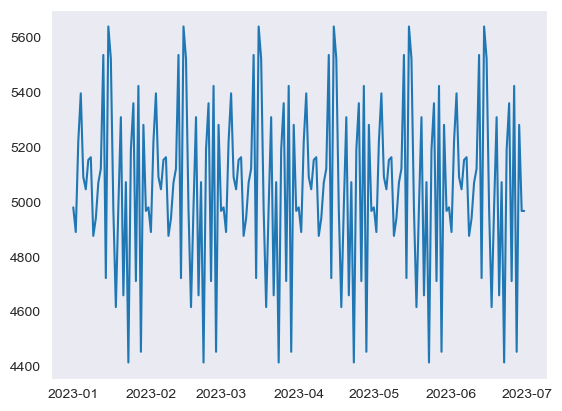

In [26]:
plt.plot(daily_df['total_transaction_count'])

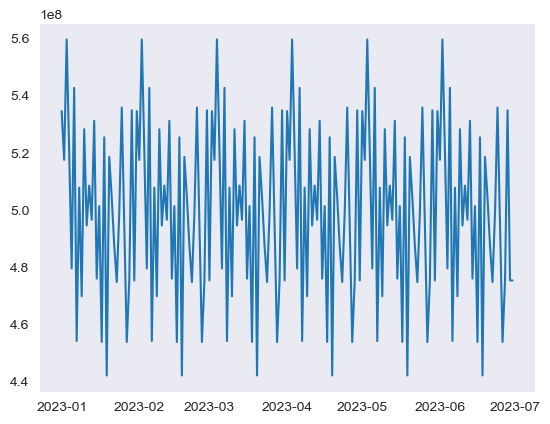

In [27]:
plt.plot(daily_df['total_transaction_amt'])

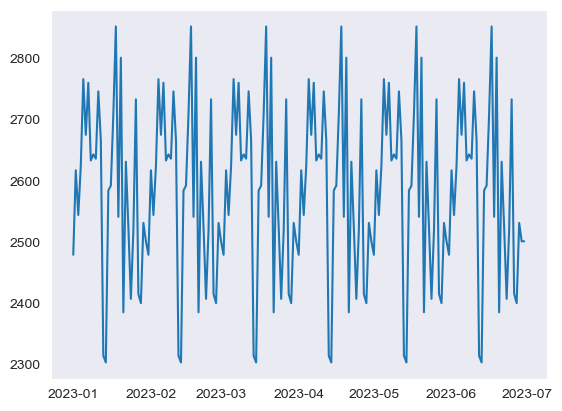

In [28]:
plt.plot(daily_df['staff_count'])

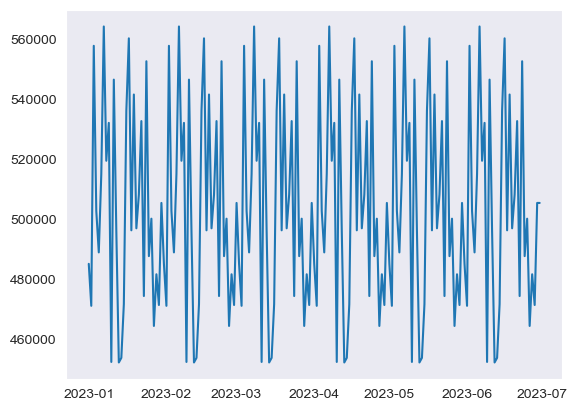

In [29]:
plt.plot(daily_df['customer_count']) 

<Axes: xlabel='total_transaction_count', ylabel='total_transaction_amt'>

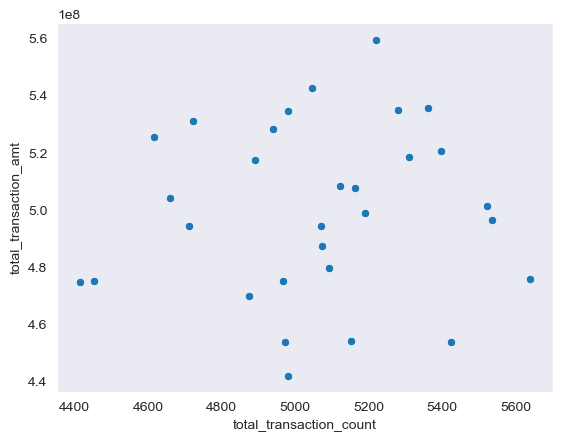

In [30]:
sns.scatterplot(data=daily_df,x='total_transaction_count',y='total_transaction_amt')

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [32]:
feature_list = daily_df.columns
lags = 30


Testing total_transaction_count


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


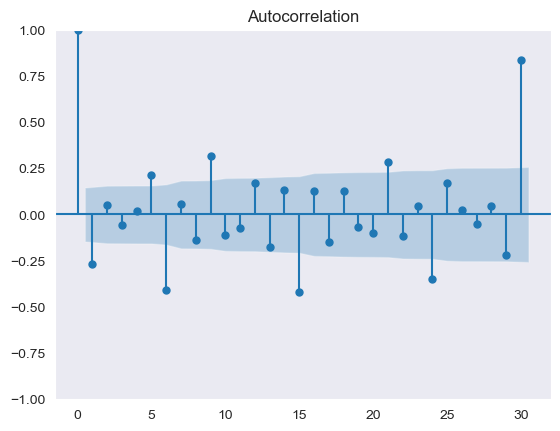

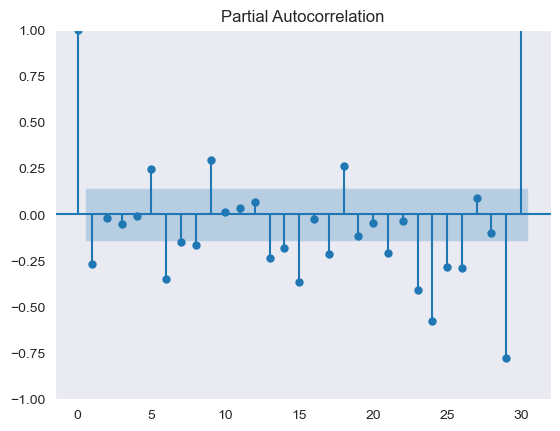

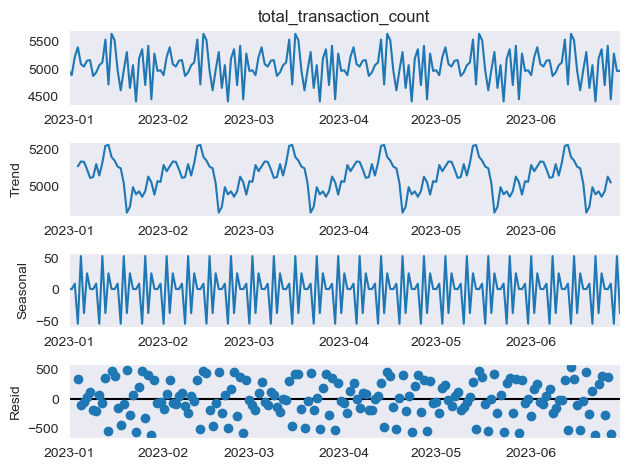

_____________________________
Testing staff_count


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


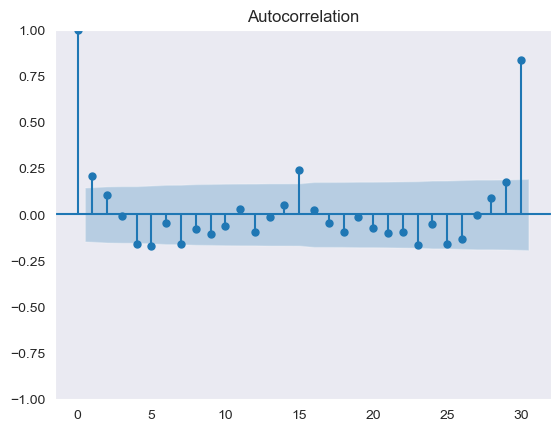

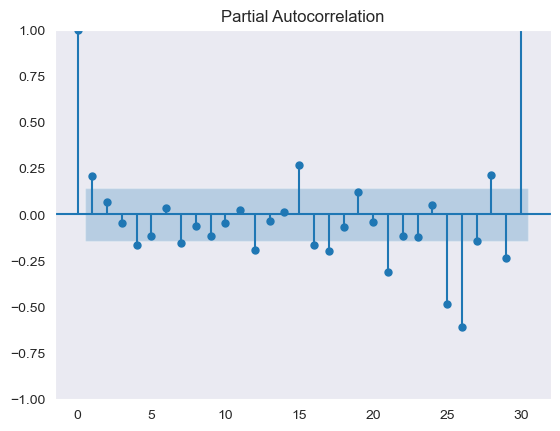

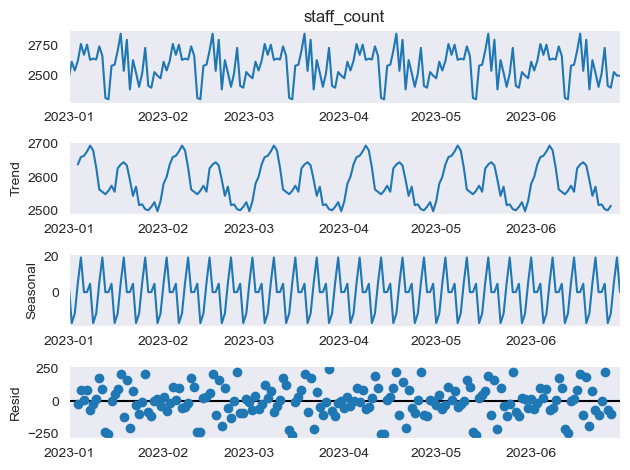

_____________________________
Testing customer_count


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


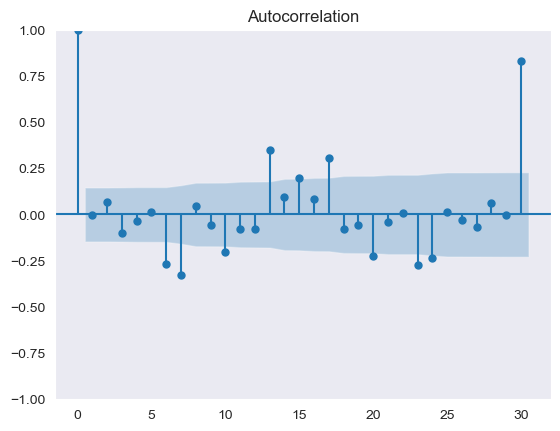

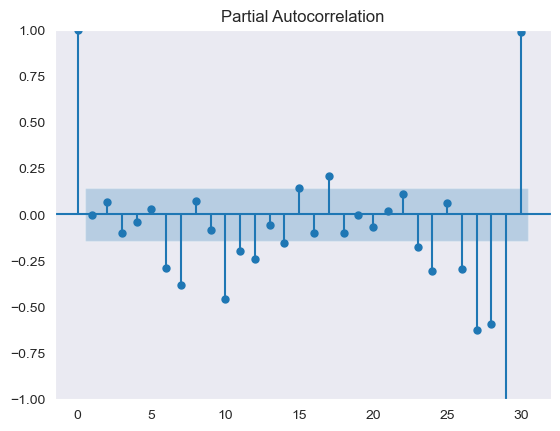

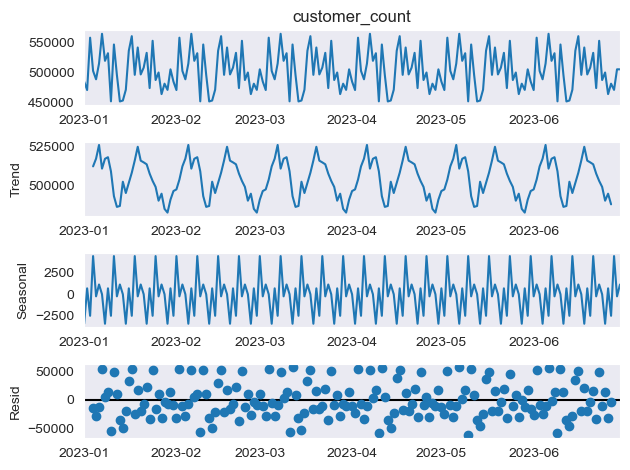

_____________________________
Testing total_transaction_amt


c:\Users\27722\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


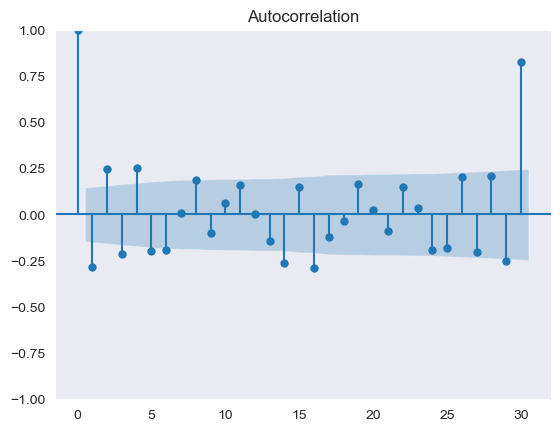

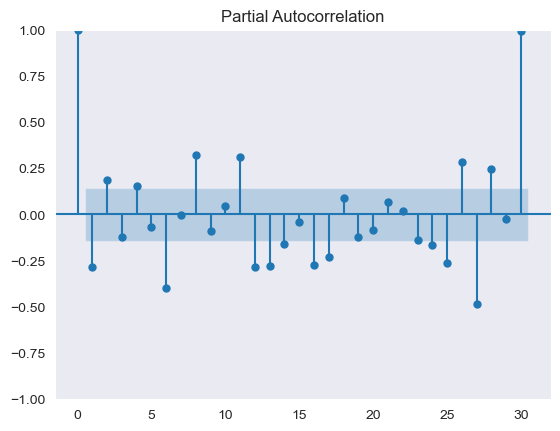

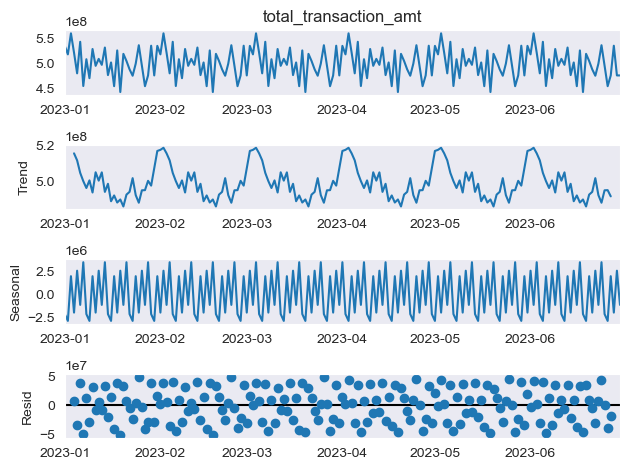

_____________________________


In [33]:
for i in feature_list:
    acf_test = daily_df[str(i)]
    print(f'Testing {i}')
    
    plot_acf(acf_test, lags=lags)
    plot_pacf(acf_test, lags=lags)
    decompose = seasonal_decompose(acf_test,model='additive', period=7)
    decompose.plot()
    plt.show()
    print('_____________________________')

## For our optimization task we're looking at achieving 3 things:
#### 1. Demand Forecasting (Time Series Problem ) - Target variable is Total number of transactions.
#### 2. Branch Activity Optimization (Regression/Classification Problem) - staffing optimization
#### 3. Customer Self-Service Recommendation (Recommendation Problem ) - Target: Recommend self-serve platforms


In [55]:
tscv = TimeSeriesSplit(n_splits=3, test_size=30)

In [50]:
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=30)

In [60]:
daily_df.reset_index(inplace=True)
daily_df

,date,total_transaction_count,staff_count,customer_count,total_transaction_amt
0,2023-01-01,4980,2479,485018,5.345117e+08
1,2023-01-02,4890,2617,471012,5.174791e+08
2,2023-01-03,5220,2544,557777,5.595778e+08
3,2023-01-04,5396,2624,502686,5.207321e+08
4,2023-01-05,5091,2766,488842,4.795098e+08
...,...,...,...,...,...
176,2023-06-26,5423,2415,464296,4.537579e+08
177,2023-06-27,4453,2400,481538,4.752965e+08
178,2023-06-28,5281,2531,471285,5.347933e+08
179,2023-06-29,4967,2501,505344,4.753049e+08


In [43]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [119]:
branch_df = raw_data[['Branch_Code','total_transaction_count','date']]

In [65]:
order = (1, 0, 3)  
seasonal_order =(1,0,9,30)
predictions_sarima = []
daily_df['predictions'] = 0

for i, (train_index, test_index) in enumerate(tscv.split(daily_df)):
    train_data = daily_df['total_transaction_count'][train_index].values
    test_data = daily_df['total_transaction_count'][test_index].values
    
    # Fit SARIMA model
    sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit()
    
    # Make predictions
    predictions = sarima_model_fit.forecast(steps=len(test_data))
    
    # Extend predictions and assign to the appropriate indices in the dataframe
    predictions_sarima.extend(predictions)
    daily_df['predictions'][test_index] = predictions

# Slice predictions array to match the length of the test data
predictions_sarima = predictions_sarima[:len(daily_df['total_transaction_count'])]

# Calculate MAPE and RMSE
mape_sarima = calculate_mape(daily_df['total_transaction_count'][-len(predictions_sarima):], predictions_sarima)
rmse_sarima = np.sqrt(mean_squared_error(daily_df['total_transaction_count'][-len(predictions_sarima):], predictions_sarima))

print("SARIMA Model MAPE: {:.2f}%".format(mape_sarima))
print("SARIMA Model RMSE: {:.2f}".format(rmse_sarima))

SARIMA Model MAPE: 0.21%
SARIMA Model RMSE: 14.25


In [69]:
sarima_model = SARIMAX(daily_df['total_transaction_count'].values, order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()


all_predictions = sarima_model_fit.forecast(steps=len(daily_df))


daily_df['predictions'] = all_predictions

mape_sarima = calculate_mape(daily_df['total_transaction_count'], daily_df['predictions'])
rmse_sarima = np.sqrt(mean_squared_error(daily_df['total_transaction_count'], daily_df['predictions']))

print("SARIMA Model MAPE: {:.2f}%".format(mape_sarima))
print("SARIMA Model RMSE: {:.2f}".format(rmse_sarima))

SARIMA Model MAPE: 7.05%
SARIMA Model RMSE: 438.93


### We now forecast for the next 30 days


In [70]:
forecast_30 = sarima_model_fit.forecast(steps=30)
forecast_30

array([4875.78097765, 5096.55196595, 5261.11235182, 5033.45815838,
       4999.62923368, 5079.11363042, 5086.28658175, 4872.05188888,
       4919.48123474, 5016.1125362 , 5053.8510497 , 5362.94485539,
       4755.84273096, 5439.91389692, 5352.41244518, 4942.11793371,
       4675.70146415, 4948.2679627 , 5191.76091236, 4706.91914168,
       5014.52387704, 4523.7186789 , 5102.67891588, 5228.38691905,
       4744.29167969, 5274.79628156, 4551.40206271, 5179.50426788,
       4923.09231063, 4930.68068529])

In [ ]:
branch_df.sort_values(by=['date','Branch_Code'],inplace=True)

In [136]:
for branch_code in branch_df['Branch_Code'].unique():
    branch_data = branch_df[branch_df['Branch_Code'] == branch_code]['total_transaction_count']
    
    sarima_model = SARIMAX(branch_data, order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit()
        
    predictions = sarima_model_fit.get_prediction(start=0, end=len(branch_data))  
    predicted_values = predictions.predicted_mean.values
    
    branch_df.loc[branch_df['Branch_Code'] == branch_code, 'predictions'] = predicted_values[1:,]
    
    
    last_30_days_predictions = predicted_values[-30:]
    predictions_sarima.extend(last_30_days_predictions)


predictions_df = pd.DataFrame({
    'branch_code': branch_df['Branch_Code'].unique(),
    'last_30_days_predictions': predictions_sarima
})

# Export predictions_df to CSV
predictions_df.to_csv('last_30_days_predictions.csv', index=False)
branch_df.to_csv('branch_forecast.csv', index=False)
# Calculate MAPE and RMSE for the entire data
mape_sarima = calculate_mape(branch_df['total_transaction_count'], branch_df['predictions'])
rmse_sarima = np.sqrt(mean_squared_error(branch_df['total_transaction_count'], branch_df['predictions']))

print("SARIMA Model MAPE: {:.2f}%".format(mape_sarima))
print("SARIMA Model RMSE: {:.2f}".format(rmse_sarima))

KeyboardInterrupt: 

In [133]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Calculate metrics
rf_mape = calculate_mape(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Random Forest Mape: {:.2f}%".format(rf_mape))
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Random Forest Mape: 4.88%
Mean Squared Error: 2.1042933701657462
Root Mean Squared Error: 1.4506182716916765
R-squared: 0.9974211916825657


In [130]:
feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_features = 5
print(f"Top {top_features} Most Important Features:")
print(feature_importance_df.head(top_features))

Top 5 Most Important Features:
                 Feature  Importance
1         customer_count    0.107736
6  kbzpay_customer_count    0.101515
3  current_account_count    0.099288
2  savings_account_count    0.098361
5   other_accounts_count    0.096350
